**Мы имеем:**
1. Два фильтра из трех.
algos.csv: две строки по 9 чисел — уцелевшие фильтры.
2. Входные изображения в одноканальном формате
Изображения (.png), которые использовались как вход.
3. Числовые матрицы — результат применения всех трех фильтров к этим изображениям (в виде .txt файлов, сохранённых через numpy.savetxt).

Каждому входному FILENAME.png файлу соответствует выходной FILENAME.txt.


Каждый фильтр — это матрица 3×3, применяемая к изображению по скользящему окну:
поэлементное произведение окна и фильтра → сумма → в соответствующую ячейку выходной матрицы. Алгоритм последовательно применяет три таких фильтра ко всему изображению.

**Задача** — восстановить недостающий фильтр и порядок применения всех трёх.
От вас ожидается восстановленный алгоритм в формате reconstructed_algos.csv, содержащем три строки по 9 чисел через запятую, в порядке применения фильтров. Первая строка соответствует первому фильтру, вторая второму, третья третьему.

Важно:
Точный ответ не требуется: оценивается среднее значение MSE между вашими фильтрами и оригинальными.

In [1]:
!mkdir best_pictures
!tar -xvf best_pictures.tar -C /content/best_pictures/ > /dev/null 2>&1

In [2]:
import numpy as np
from scipy.signal import correlate2d
from PIL import Image
import os
from itertools import permutations

# Загрузка известных фильтров
known_filters = np.loadtxt('best_pictures/algos.csv', delimiter=',')
F1 = known_filters[0].reshape(3, 3)
F2 = known_filters[1].reshape(3, 3)

# Загрузка изображений и выходных матриц
image_folder = 'best_pictures'
output_files = [f for f in os.listdir(image_folder) if f.endswith('.txt') and not f.startswith('.')]

file_image_output_pairs = []

for f in output_files:
    file_index = int(f.split('.')[0])
    img_name = f.replace('.txt', '.png')
    img_path = os.path.join(image_folder, img_name)

    if not os.path.exists(img_path):
        continue

    img = np.array(Image.open(img_path))
    output = np.loadtxt(os.path.join(image_folder, f))

    file_image_output_pairs.append((file_index, f, img, output))

file_image_output_pairs.sort(key=lambda x: x[0])
_, output_files, images, outputs = zip(*file_image_output_pairs)
images = list(images)
outputs = list(outputs)

In [3]:
F1

array([[-1. , -0.5,  0. ],
       [-0.5,  0.5,  0.5],
       [ 0. ,  0.5,  1. ]])

In [4]:
F2

array([[0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625]])

In [5]:
def build_and_solve(images, outputs, filter_sequence):
    A_list = []
    b_list = []
    for X, Y in zip(images, outputs):
        B = X.astype(np.float64)
        for f in filter_sequence:
            if f is not None:
                B = correlate2d(B, f, mode='same')
        H, W = Y.shape
        for i in range(1, H-1):
            for j in range(1, W-1):
                window = B[i-1:i+2, j-1:j+2]
                A_list.append(window.flatten())
                b_list.append(Y[i, j])
    A = np.array(A_list)
    b = np.array(b_list)
    f_missing, res, _, _ = np.linalg.lstsq(A, b, rcond=None)
    mse = np.mean((A @ f_missing - b) ** 2)
    return f_missing.reshape(3, 3), mse

best_mse = np.inf
best_filters = None

# Перебор всех возможных позиций недостающего фильтра
for missing_pos in [0, 1, 2]:
    # Генерация всех возможных последовательностей с недостающим фильтром
    for perm in permutations([F1, F2]):
        # Создаем шаблон с недостающим фильтром
        current_seq = []
        known_idx = 0
        for i in range(3):
            if i == missing_pos:
                current_seq.append(None)
            else:
                current_seq.append(perm[known_idx])
                known_idx += 1

        # Решаем для текущей гипотезы
        missing_f, mse = build_and_solve(images, outputs, current_seq)

        # Формируем полную последовательность фильтров
        final_seq = []
        for f in current_seq:
            if f is None:
                final_seq.append(missing_f.flatten())
            else:
                final_seq.append(f.flatten())

        # Вывод текущего состояния
        print(f"  Позиция недостающего фильтра: {missing_pos + 1}")
        print(f"  Порядок известных фильтров: {[f.tolist() for f in perm]}")
        print(f"  MSE: {mse}")

        # Обновляем лучший результат
        if mse < best_mse:
            print("  Найдено улучшение!")
            best_mse = mse
            best_filters = final_seq

# Вывод результатов
print(f"Лучший MSE: {best_mse}")
print("Найденные фильтры:")
for i, filt in enumerate(best_filters):
    print(f"Фильтр {i+1}:\n{filt.reshape(3,3)}")

  Позиция недостающего фильтра: 1
  Порядок известных фильтров: [[[-1.0, -0.5, 0.0], [-0.5, 0.5, 0.5], [0.0, 0.5, 1.0]], [[0.0625, 0.0625, 0.0625], [0.0625, 0.0625, 0.0625], [0.0625, 0.0625, 0.0625]]]
  MSE: 59.9379764618162
  Найдено улучшение!
  Позиция недостающего фильтра: 1
  Порядок известных фильтров: [[[0.0625, 0.0625, 0.0625], [0.0625, 0.0625, 0.0625], [0.0625, 0.0625, 0.0625]], [[-1.0, -0.5, 0.0], [-0.5, 0.5, 0.5], [0.0, 0.5, 1.0]]]
  MSE: 2.074458684118623e-26
  Найдено улучшение!
  Позиция недостающего фильтра: 2
  Порядок известных фильтров: [[[-1.0, -0.5, 0.0], [-0.5, 0.5, 0.5], [0.0, 0.5, 1.0]], [[0.0625, 0.0625, 0.0625], [0.0625, 0.0625, 0.0625], [0.0625, 0.0625, 0.0625]]]
  MSE: 59.9379764618162
  Позиция недостающего фильтра: 2
  Порядок известных фильтров: [[[0.0625, 0.0625, 0.0625], [0.0625, 0.0625, 0.0625], [0.0625, 0.0625, 0.0625]], [[-1.0, -0.5, 0.0], [-0.5, 0.5, 0.5], [0.0, 0.5, 1.0]]]
  MSE: 2.074458684118623e-26
  Позиция недостающего фильтра: 3
  Порядок изве

In [6]:
F3 = best_filters[0]
F3

array([0.125, 0.25 , 0.125, 0.25 , 0.5  , 0.25 , 0.125, 0.25 , 0.125])

Тут выводится округленное число, настоящий результат работы алгоритма:

```array([[0.124999999999999375,0.250000000000004885,0.124999999999997016],[0.249999999999996891,0.500000000000001887,0.250000000000001055],[0.124999999999999001,0.250000000000000555,0.124999999999999598]])```

In [40]:
def apply_convolution(image, filters):
    result = image.astype(np.float64)
    for f in filters:
        result = correlate2d(result, f.astype(np.float64), mode='same')
    return result

np.set_printoptions(precision=15, suppress=False)

F3 = np.array([[0.124999999999999375,0.250000000000004885,0.124999999999997016],[0.249999999999996891,0.500000000000001887,0.250000000000001055],[0.124999999999999001,0.250000000000000555,0.124999999999999598]])
F3_rounded = np.array([[0.125, 0.25, 0.125], [0.25, 0.5, 0.25 ], [0.125, 0.25, 0.125]], dtype=np.float64)
print(apply_convolution(images[0], [F2, F3_rounded, F1]))

[[ 324.81640625  364.234375    353.43359375 ...  326.73828125
   229.59765625   33.4296875 ]
 [ 339.8203125   287.3828125   229.90234375 ...  166.51953125
    54.49609375 -134.234375  ]
 [ 289.40234375  188.03515625  113.96484375 ...   55.84765625
   -46.609375   -207.77734375]
 ...
 [ 227.94921875  131.46875      66.82421875 ...   20.4140625
   -33.46484375 -130.69140625]
 [ 158.03125      54.953125     -8.49609375 ...  -30.85546875
   -69.5234375  -135.56640625]
 [  23.84765625  -83.91796875 -141.98828125 ... -111.99609375
  -124.3828125  -131.65234375]]


In [8]:
print(outputs[0])

[[ 324.81640625  364.234375    353.43359375 ...  326.73828125
   229.59765625   33.4296875 ]
 [ 339.8203125   287.3828125   229.90234375 ...  166.51953125
    54.49609375 -134.234375  ]
 [ 289.40234375  188.03515625  113.96484375 ...   55.84765625
   -46.609375   -207.77734375]
 ...
 [ 227.94921875  131.46875      66.82421875 ...   20.4140625
   -33.46484375 -130.69140625]
 [ 158.03125      54.953125     -8.49609375 ...  -30.85546875
   -69.5234375  -135.56640625]
 [  23.84765625  -83.91796875 -141.98828125 ... -111.99609375
  -124.3828125  -131.65234375]]


array([[174, 160, 172, ..., 182, 223, 244],
       [213, 226, 184, ..., 223, 217, 154],
       [163, 202, 194, ..., 165, 127, 135],
       ...,
       [137, 131, 122, ...,  99, 100, 114],
       [136, 129, 118, ...,  85,  89, 112],
       [132, 125, 117, ...,  73,  91, 109]], dtype=uint8)
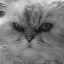

In [9]:
images[0]

In [42]:
def mse(matrix1, matrix2):
    matrix1 = np.asarray(matrix1, dtype=np.float64)
    matrix2 = np.asarray(matrix2, dtype=np.float64)

    if matrix1.shape != matrix2.shape:
        raise ValueError(f"Размеры матриц не совпадают: {matrix1.shape} vs {matrix2.shape}")

    return np.mean(np.square(matrix1 - matrix2))

print(f"MSE: {mse(apply_convolution(images[0], [F2, F3, F1]), outputs[0])}")
print(f"MSE: {mse(apply_convolution(images[0], [F2, F3_rounded, F1]), outputs[0]):.15e}")

MSE: 3.994862498261157e-27
MSE: 0.000000000000000e+00


In [29]:
s = 0
for i in range(len(images)):
  s += mse(apply_convolution(images[i], [F2, F3_rounded, F1]), outputs[i])
print(s)

0.0


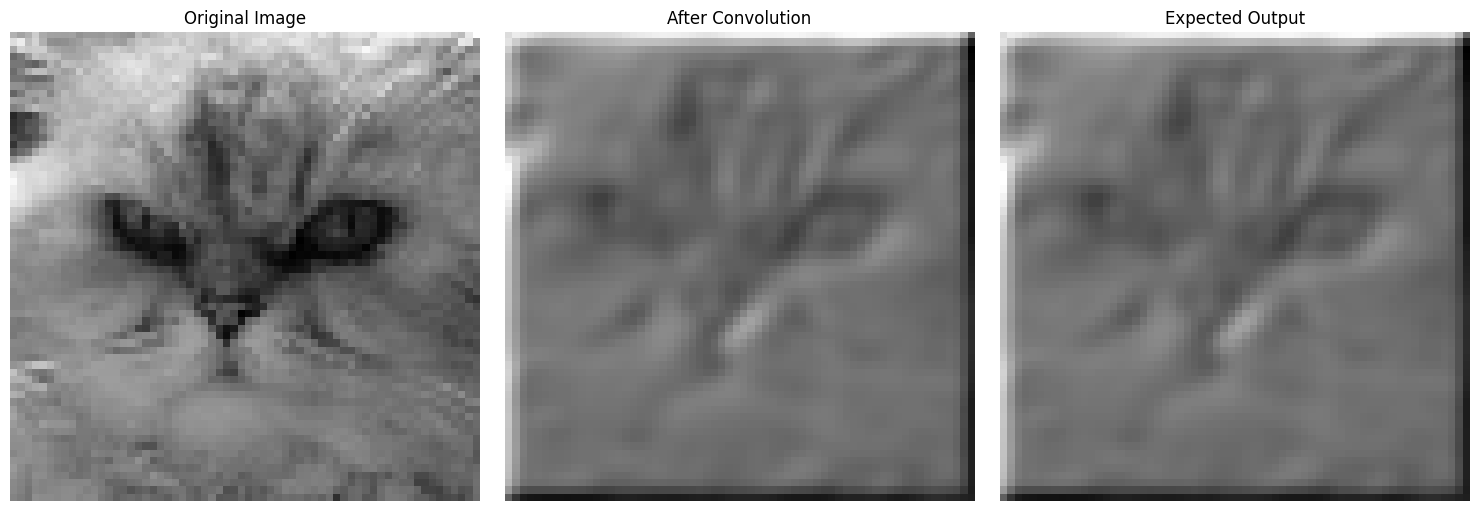

In [57]:
import matplotlib.pyplot as plt

result_image = apply_convolution(images[0], [F2, F3_rounded, F1])

# Визуализация
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(images[0], cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(result_image, cmap='gray')
axs[1].set_title('After Convolution')
axs[1].axis('off')

axs[2].imshow(outputs[0], cmap='gray')
axs[2].set_title('Expected Output')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [58]:
best_filters[0] = F3_rounded
# Преобразуем все фильтры в одномерные массивы
for i in range(len(best_filters)):
    if best_filters[i].ndim == 2:  # Если элемент — это матрица
        best_filters[i] = best_filters[i].flatten()  # Преобразуем в вектор
np.savetxt('reconstructed_algos.csv', best_filters, delimiter=',', fmt='%.18f')